In [1]:
import numpy as np
from model_aug_shiftx import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (im_size, im_size))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/shiftx_5px_aug_inplace_lr0.0002/checkpoint"
sample_dir = "./out/shiftx_5px_aug_inplace_lr0.0002/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

# flags = tf.app.flags
# flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
# flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
# flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
# flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
# flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
# flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
# flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
# flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
# flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
# flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
# flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
# flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
# flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
# flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# # flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# # with aug:
# # flags.DEFINE_string("checkpoint_dir", "./out/20190814.150034_data_mnist_x28.z100.uniform_signed.y28.b64_with_aug_inplace_5px_shift/checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# # without aug:
# flags.DEFINE_string("checkpoint_dir", "./out/20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64_without_aug_5px_shift/checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# # flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
# flags.DEFINE_string("sample_dir", "./out/20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64/samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
# flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
# flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
# flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
# flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
# flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
# flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
# flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
# flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
# flags.DEFINE_integer("z_dim", 100, "dimensions of z")
# flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
# flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
# flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
# #flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# # only for jupyter:
# flags.DEFINE_string('f', '', 'kernel')

# FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
# dcgan = DCGAN(
#     sess,
#     input_width=28,
#     input_height=28,
#     output_width=28,
#     output_height=28,
#     batch_size=64,
#     sample_num=64,
#     y_dim=10,
#     z_dim=100,
#     dataset_name='mnist',
#     input_fname_pattern='*.jpg',
#     crop=False,
#     checkpoint_dir='20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64/checkpoint',
# #     out_name='20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64',
#     sample_dir='samples',
#     data_dir='./data',
#     out_dir='./out',
#     max_to_keep=1)
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

loading mnist...
 [*] Reading checkpoints... ./out/shiftx_5px_aug_inplace_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from ./out/shiftx_5px_aug_inplace_lr0.0002/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


In [8]:
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)


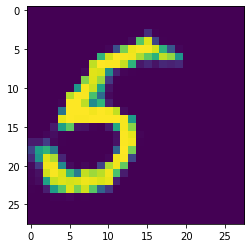

In [9]:
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(10, num_samples)
y_one_hot = np.zeros((num_samples, 10))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [10]:
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

# inputs_orig = {u'y': y_placeholder, u'z': z_placeholder}
# outputs_orig = dcgan.generator(inputs_orig)
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

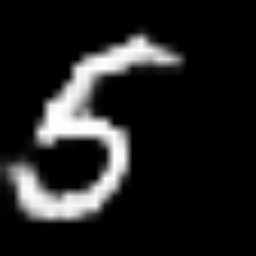

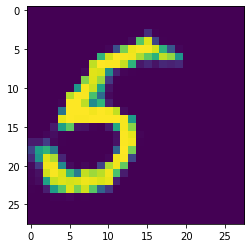

In [11]:
samples = sess.run(outputs_orig, feed_dict={z_placeholder: z_sample, y_placeholder: y_one_hot})
plt.imshow(samples[0,:,:,0])
imshow(samples[0,:,:,0])

In [12]:
img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)


In [13]:
z_new = z_placeholder+alpha*w
y_new = y_placeholder
transformed_output = dcgan.my_sampler(z_new, y_new)

In [14]:
loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.05
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

In [15]:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [16]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    print('outputs_zs.shape', outputs_zs.shape)
    if alpha == 0:
        return outputs_zs, mask_fn
    
    M = np.float32([[1,0,alpha],[0,1,0]])
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
        
    if show_img:
        print('Target image:')
#         imshow_unscaled(target_fn)
        imshow(target_fn[0,:,:,0], im_size=128)
    if show_mask:
        print('Target mask:')
#         imshow_unscaled(mask_out)
        imshow(mask_out[0,:,:,0], im_size=128)

    return target_fn, mask_out

In [17]:
! mkdir -p shift_l2_git/images
! mkdir -p shift_l2_git/output
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [18]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format('shift_l2_git', 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []

# train
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples=4000
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []

    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 6)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)
            Loss_sum = Loss_sum + curr_loss
            loss_values.append(curr_loss)

            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))
                
            alpha_list.append(alpha_val)

            if (optim_iter % 100 == 0) and (optim_iter > 0):
                saver.save(sess, './shift_l2_git/model_{}.ckpt'.format(optim_iter*batch_size), write_meta_graph=False, write_state=False)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, "./shift_l2_git/model_{}_final.ckpt".format(optim_iter*batch_size), write_meta_graph=False, write_state=False)
    return loss_values

In [19]:
train(dcgan.saver)

outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:27,981 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.2928299903869629, 0, 0, 0.27604538202285767, 4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:27,989 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006861448287963867, 0, 10, 0.15442293882369995, -4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:27,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007875919342041016, 0, 20, 0.09160419553518295, 1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,006 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00807642936706543, 0, 30, 0.12718458473682404, 2
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,017 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009521007537841797, 0, 40, 0.07477961480617523, -1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,026 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008096694946289062, 0, 50, 0.13344742357730865, 3
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,035 [MainThread  ] [INFO 

outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,422 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008881092071533203, 0, 530, 0.14015479385852814, -5
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,430 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00746917724609375, 0, 540, 0.10524537414312363, -4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,440 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008562803268432617, 0, 550, 0.09037625789642334, 3
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,447 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00666356086730957, 0, 560, 0.12657839059829712, 5
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,455 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0075948238372802734, 0, 570, 0.023579956963658333, 1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,466 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009849309921264648, 0, 580, 0.08106419444084167, 3
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:28,472 [MainThread

outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,295 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00983119010925293, 0, 1060, 0.0892312154173851, 4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,303 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007306575775146484, 0, 1070, 0.018109623342752457, -1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,310 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006839752197265625, 0, 1080, 0.12417219579219818, -4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,317 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005791902542114258, 0, 1090, 0.11973115056753159, 5
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,324 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0062847137451171875, 0, 1100, 0.04567507281899452, 2
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,331 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006453752517700195, 0, 1110, 0.09881199151277542, 5
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,338 [Main

outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,669 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006704092025756836, 0, 1590, 0.07991167157888412, 3
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,676 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0063800811767578125, 0, 1600, 0.0302746444940567, -1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,685 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008382797241210938, 0, 1610, 0.033627308905124664, 1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,693 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007670402526855469, 0, 1620, 0.031383030116558075, 1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,702 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007809638977050781, 0, 1630, 0.09086973965167999, 4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,715 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0123748779296875, 0, 1640, 0.0253742728382349, 1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:32,725 [MainTh

outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:36,748 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007109403610229492, 0, 2120, 0.022826820611953735, 1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:36,756 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00693202018737793, 0, 2130, 0.09468970447778702, 4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:36,765 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007277011871337891, 0, 2140, 0.11552949249744415, -5
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:36,773 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007744789123535156, 0, 2150, 0.11273756623268127, 5
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:36,781 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069425106048583984, 0, 2160, 0.04663746431469917, -2
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:36,789 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006614208221435547, 0, 2170, 0.08731058239936829, 3
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:36,796 [Mai

outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:37,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009323835372924805, 0, 2650, 0.12032746523618698, 3
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:37,211 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008711099624633789, 0, 2660, 0.10173765569925308, -3
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:37,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0076258182525634766, 0, 2670, 0.14340700209140778, 5
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:37,228 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007517814636230469, 0, 2680, 0.10105565935373306, 2
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:37,242 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012077093124389648, 0, 2690, 0.10026214271783829, -1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:37,252 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008545160293579102, 0, 2700, 0.1209307387471199, 2
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:37,262 [Main

outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:40,673 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0064432621002197266, 0, 3180, 0.08354063332080841, -4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:40,680 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00631260871887207, 0, 3190, 0.04041106626391411, 2
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:40,687 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006701946258544922, 0, 3200, 0.06897539645433426, -3
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:40,695 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006814241409301758, 0, 3210, 0.10302042216062546, 4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:40,703 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006870269775390625, 0, 3220, 0.047457676380872726, 2
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:40,710 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006436347961425781, 0, 3230, 0.09130353480577469, -4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:40,717 [Ma

outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:41,094 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00685429573059082, 0, 3710, 0.10190942138433456, -4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:41,102 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007260322570800781, 0, 3720, 0.020957188680768013, -1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:41,110 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007164955139160156, 0, 3730, 0.10890055447816849, -4
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:41,118 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0072171688079833984, 0, 3740, 0.02599346823990345, 1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:41,126 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007135629653930664, 0, 3750, 0.02147850953042507, -1
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:41,135 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008237838745117188, 0, 3760, 0.08597142994403839, 3
outputs_zs.shape (10, 28, 28, 1)
2019-09-09 21:21:41,142 [M

[0.27604538,
 0.15442294,
 0.091604196,
 0.12718458,
 0.074779615,
 0.13344742,
 0.14178815,
 0.12521428,
 0.1626071,
 0.12486197,
 0.14865632,
 0.18798849,
 0.13164146,
 0.036426775,
 0.17077889,
 0.114742205,
 0.07532634,
 0.1319426,
 0.09161185,
 0.1974711,
 0.07473548,
 0.06376668,
 0.09186171,
 0.13772267,
 0.1664484,
 0.123091534,
 0.11830396,
 0.12799694,
 0.11249041,
 0.13150294,
 0.12850627,
 0.21940973,
 0.1631395,
 0.17989889,
 0.12729493,
 0.063278094,
 0.049400173,
 0.061853442,
 0.15501371,
 0.17028081,
 0.11949416,
 0.09608613,
 0.12797482,
 0.049469367,
 0.09828637,
 0.02352474,
 0.20463732,
 0.1877436,
 0.11001739,
 0.022879085,
 0.10768364,
 0.06693705,
 0.090196736,
 0.1401548,
 0.105245374,
 0.09037626,
 0.12657839,
 0.023579957,
 0.081064194,
 0.0985468,
 0.105827205,
 0.055764828,
 0.117314145,
 0.023148673,
 0.06528969,
 0.06236966,
 0.111350335,
 0.09011477,
 0.031771436,
 0.052999258,
 0.026443599,
 0.10280142,
 0.1211582,
 0.070849046,
 0.061302025,
 0.0662874

In [ ]:
# test: show imgs 
# saver.restore(sess, "./shift_l2_git/model_4000_final.ckpt")

In [20]:
num_samples = 11
im_targets = []
im_transformed = []
lower_bound = -8
a = np.arange(lower_bound, -lower_bound+1, 1)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.random.choice(FLAGS.y_dim, num_samples)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

In [21]:
 
for s in range(10):
    for i in range(a.shape[0]):
        feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
        out_zs = sess.run(outputs_orig, feed_dict_out)
        target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
        im_targets.append(targets)
        # get transformed:
#         samples = sess.run(dcgan.sampler_new, feed_dict = {dcgan.z: z_sample, 
#                                                        dcgan.y: y_one_hot, 
#                                                        dcgan.alpha: np.expand_dims(alpha[:,i],axis=1)})
#         im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

InvalidArgumentError: Input to reshape is a tensor with 110 values, but the requested shape has 100
	 [[node generator_2/Reshape (defined at /afs/csail.mit.edu/u/j/jahanian/ibig/ibig_git/gan_workspace/DCGAN-tensorflow/model_aug_shiftx.py:552)  = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_y_sample_0_0/_81, generator_2/Reshape/shape)]]
	 [[{{node generator_2/Sigmoid/_83}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_138_generator_2/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'generator_2/Reshape', defined at:
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-71ac9f128642>", line 6, in <module>
    outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)
  File "/afs/csail.mit.edu/u/j/jahanian/ibig/ibig_git/gan_workspace/DCGAN-tensorflow/model_aug_shiftx.py", line 552, in my_sampler
    yb = tf.reshape(y, [self.batch_size, 1, 1, self.y_dim])
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6482, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/afs/csail.mit.edu/u/j/jahanian/.conda/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 110 values, but the requested shape has 100
	 [[node generator_2/Reshape (defined at /afs/csail.mit.edu/u/j/jahanian/ibig/ibig_git/gan_workspace/DCGAN-tensorflow/model_aug_shiftx.py:552)  = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_y_sample_0_0/_81, generator_2/Reshape/shape)]]
	 [[{{node generator_2/Sigmoid/_83}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_138_generator_2/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
# test: show imgs 
# this can be test.py

np.random.seed(0)
categories = np.random.choice(10, 10, replace=False)
# categories = [449] # [207, 283, 751, 949, 963, 973, 970, 978]

a = np.arange(-5,6,1)
 
num_samples=10

for c in range(len(categories)):

    ims_zoomed = []
    ims_target = []
    ims_mask = []

    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    y = np.random.choice(10, num_samples)
    ys = np.zeros((num_samples, 10))
    ys[np.arange(num_samples), y] = 1

    input_test = {y_placeholder: ys,
                  z_placeholder: zs}
    
    out_input_test = sess.run(outputs_orig, input_test)
    print('Input image:')    
#     print(np.expand_dims(out_input_test[0,:,:,:], 0).shape)
    # imshow_unscaled(np.expand_dims(out_input_test[0,:,:,:], 0))
    
    for i in range(a.shape[0]):
        print('Target image with alpha={}:'.format(a[i]))
        target_fn, mask_out = get_target_np(out_input_test, a[i], show_img=False)
        best_inputs = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}#, input_step_sizes: step_sizes}
        best_im_out, best_loss = sess.run([transformed_output, loss], best_inputs)
        baseline_loss = sess.run(loss, feed_dict={mask: mask_out, target: target_fn, 
                                                  transformed_output: out_input_test})
        
        print('Transformed image with alpha={}, {}pix shift:'.format(a[i], a[i]))
        # imshow_unscaled(np.expand_dims(best_im_out[0,:,:,:], 0))
        # imshow_unscaled(best_im_out)
        
        # collect outputs
        ims_zoomed.append(best_im_out)
        ims_target.append(target_fn)
        ims_mask.append(mask_out)
    
   # save image without mask
    ims = []
    for j in range(min(num_samples, 3)):
        top_row = np.stack([x[j, :, :, :] for x in ims_target], axis=0)
        top_row = np.uint8 (np.clip(((top_row + 1) / 2.0) * 256, 0, 255))
        bottom_row = np.stack([x[j, :, :, :] for x in ims_zoomed], axis=0)
        bottom_row = np.uint8(np.clip(((bottom_row + 1) / 2.0) * 256, 0, 255))
        # add a green stripe down the center for alignment
        _, _, width, _ = top_row.shape
#         top_row[:, :, width//2-1:width//2+3, 0] = 255
#         bottom_row[:, :, width//2-1:width//2+3, 0] = 255
        ims.append(np.concatenate((top_row,bottom_row), axis=0))
    ims = np.concatenate(ims, axis=0)
    imshow(imgrid(ims, cols=len(a)), filename='shift_l2_git/images/grouped-{}-{}'.format(categories[c], 0))
    
    # save image with mask
    ims = []
    for j in range(min(num_samples, 3)):
        top_row = np.stack([x[j, :, :, :] for x in ims_target], axis=0)
        top_row = np.uint8 (np.clip(((top_row + 1) / 2.0) * 256, 0, 255))
        bottom_row = np.stack([x[j, :, :, :] * y[j, :, :, :] for x, y in zip(ims_zoomed, ims_mask)], axis=0)
        bottom_row = np.uint8(np.clip(((bottom_row + 1) / 2.0) * 256, 0, 255))
        # add a green stripe down the center for alignment
        _, _, width, _ = top_row.shape
#         top_row[:, :, width//2-1:width//2+3, 0] = 255
#         bottom_row[:, :, width//2-1:width//2+3, 0] = 255
        ims.append(np.concatenate((top_row,bottom_row), axis=0))
    ims = np.concatenate(ims, axis=0)
    imshow(imgrid(ims, cols=len(a)), filename='shift_l2_git/images/grouped-{}-{}-mask'.format(categories[c], 0))
    
    
    